# Deep Learning Models

Authored by [witchapong](https://github.com/witchapong); Edited by [cstorm125](https://github.com/cstorm125/)

This notebook details how to tackle the recommendation problem using deep learning models. We provide two example models: one where all variables are treated as cross-sectional variables, and the other where previous snaps are treated as sequential variables.

In [ ]:
# #uncomment if you are running from google colab
# !wget https://github.com/Datatouille/snaplogic_snap_recommendation/archive/master.zip; unzip master
# !mv snaplogic_snap_recommendation-master/* .
# !ls

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from copy import deepcopy
from utils import *
np.set_printoptions(threshold=50, edgeitems=20)

#torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda', index=0)

## Load Data

In [3]:
train_df = pd.read_csv("dataset/train_df.csv")
valid_df = pd.read_csv("dataset/valid_df.csv")
submit_df = pd.read_csv("dataset/submit_df.csv")
all_df = pd.concat([train_df,valid_df,submit_df],0).reset_index(drop=True)
train_df.shape, valid_df.shape, submit_df.shape

((103541, 8), (14792, 8), (29584, 8))

In [4]:
train_df.head()

,org,prev_snap_1,prev_snap_2,prev_snap_3,prev_snap_4,project,target_snap,user
0,3,471,158,0,0,500,286,118
1,1,238,468,0,0,396,63,7
2,3,344,344,344,344,500,349,168
3,3,171,0,0,0,217,211,71
4,3,0,0,0,0,565,51,71


In [5]:
train_df.describe()

,org,prev_snap_1,prev_snap_2,prev_snap_3,prev_snap_4,project,target_snap,user
count,103541.000000,103541.000000,103541.000000,103541.000000,103541.000000,103541.000000,103541.000000,103541.000000
mean,2.674303,185.961629,133.142716,88.953873,54.087231,443.124125,266.926358,128.956510
std,0.737418,152.789966,156.076242,143.168823,120.032965,126.777504,129.226959,52.766921
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,3.000000,30.000000,0.000000,0.000000,0.000000,500.000000,158.000000,71.000000
50%,3.000000,158.000000,66.000000,0.000000,0.000000,500.000000,287.000000,118.000000
75%,3.000000,313.000000,211.000000,158.000000,0.000000,500.000000,349.000000,168.000000
max,4.000000,500.000000,500.000000,500.000000,499.000000,580.000000,500.000000,230.000000


## Cross-sectional Model

In this model, our features are indice of previous snaps, organizations, projects and users. We treat all of them as cross-sectional, categorical variables. The output of the model is the probability of the target snap.

### Dataloaders

We create dataloaders for train and validation sets. They simply output each row of the dataframe.

In [6]:
class SnapStaDataset(Dataset):
    def __init__(self, df, sta_cols, target_col):
        self.df  = df
        self.sta = df[sta_cols]
        self.target = df[target_col]

    def __getitem__(self, index):
        return(torch.tensor(self.sta.iloc[index], dtype=torch.long, device=device),
               torch.tensor(self.target[index], dtype=torch.long, device=device))

    def __len__(self):
        return(self.df.shape[0])

In [7]:
sta_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1','org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapStaDataset(train_df, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = SnapStaDataset(valid_df, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)

In [8]:
next(iter(train_dl))

[tensor([[  0,   0, 344,  ...,   3, 500, 118],
         [  0,   0,   0,  ...,   3, 500, 118],
         [  0,   0,  38,  ...,   3, 500, 168],
         ...,
         [ 79,  79, 158,  ...,   3, 500, 168],
         [  0,   0,   0,  ...,   3, 500,  71],
         [  0,   0,   0,  ...,   1, 195, 201]], device='cuda:0'),
 tensor([344, 158, 349,  ...,  79,  79, 470], device='cuda:0')]

### Architecture

The architecture consists of embedding layers that convert all categorical indice to tensors then concatenate them together. After that, we put the concatenated tensors through non-linearity layers, lastly, outputing probabilities for the target snap.

In [11]:
pd.concat([train_df,valid_df],axis=0).describe()

,org,prev_snap_1,prev_snap_2,prev_snap_3,prev_snap_4,project,target_snap,user
count,118333.000000,118333.000000,118333.000000,118333.00000,118333.000000,118333.000000,118333.000000,118333.000000
mean,2.714619,186.760101,134.423272,89.92565,54.819408,452.348128,267.080595,125.979828
std,0.698465,152.714594,156.621822,143.96719,121.071679,121.656760,128.535729,50.547574
min,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000
25%,3.000000,36.000000,0.000000,0.00000,0.000000,500.000000,158.000000,71.000000
50%,3.000000,158.000000,71.000000,0.00000,0.000000,500.000000,287.000000,118.000000
75%,3.000000,313.000000,212.000000,158.00000,0.000000,500.000000,349.000000,168.000000
max,4.000000,500.000000,500.000000,500.00000,499.000000,580.000000,500.000000,230.000000


In [12]:
sta_dict = {'prev_snap_4': 501, 'prev_snap_3': 501, 'prev_snap_2': 501, 'prev_snap_1': 501,
            'org':5, 'project':581, 'user':231}
config = {'emb_p': 0.05, 'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500],  'out_sz': 501}

#rule of thump for choosing embedding size from fastai
def emb_sz_rule(n_cat): return min(600, round(1.6 * n_cat**0.56))

class RecommendSta(nn.Module):
    def __init__(self, config, sta_dict):
        super(RecommendSta, self).__init__()
        #set parameters
        self.sta_dict = sta_dict
        self.emb_p = config['emb_p']
        self.fc_szs = config['fc_szs']
        self.fc_ps = config['fc_ps']
        self.out_sz = config['out_sz']
        
        #embedding layers
        self.emb_drop = nn.Dropout(self.emb_p)
        self.sta_layers = nn.ModuleList([nn.Embedding(sta_dict[i], emb_sz_rule(sta_dict[i])) for i in sta_dict])
        self.lin_in = sum([emb_sz_rule(sta_dict[i]) for i in sta_dict])
        self.fc_szs = [self.lin_in] + self.fc_szs
        
        #fully connected layers
        fc_layers_list = []
        for ni,nf,p in zip(self.fc_szs[:-1], self.fc_szs[1:], self.fc_ps):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        #output head
        self.head = torch.nn.Linear(in_features=self.fc_szs[-1], out_features=self.out_sz)

    def forward(self, sta_input):
        #sta
        sta_list = [e(sta_input[:,i]) for i,e in enumerate(self.sta_layers)]
        sta_out = torch.cat(sta_list,1)
        sta_out = self.emb_drop(sta_out)
        
        #linear
        res = self.fc_layers(sta_out)
        res = self.head(res)
    
        return(res)

In [13]:
model = RecommendSta(config, sta_dict).to(device)
x = next(iter(valid_dl))
sta_input = x[0]
target = x[1]
model(sta_input).shape

torch.Size([14792, 501])

In [14]:
model

RecommendSta(
  (emb_drop): Dropout(p=0.05)
  (sta_layers): ModuleList(
    (0): Embedding(501, 52)
    (1): Embedding(501, 52)
    (2): Embedding(501, 52)
    (3): Embedding(501, 52)
    (4): Embedding(5, 4)
    (5): Embedding(581, 57)
    (6): Embedding(231, 34)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=303, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
  )
  (head): Linear(in_features=500, out_features=501, bias=True)
)

### Training

We perform training with a high learning rate then gradually lowers it as validation loss stagnates.

In [15]:
sta_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1','org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapStaDataset(train_df, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = SnapStaDataset(valid_df, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)

In [16]:
sta_dict = {'prev_snap_4': 501, 'prev_snap_3': 501, 'prev_snap_2': 501, 'prev_snap_1': 501,
            'org':5, 'project':581, 'user':231}
config = {'emb_p': 0.05, 'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500],  'out_sz': 501}

model = RecommendSta(config, sta_dict).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

In [17]:
train_losses = []
valid_losses = []
lrs = []
accs = []
acc_ks = []
best_loss = np.inf
best_weights = None
no_improvements = 0

for epoch in tqdm_notebook(range(20)):
    #current lr
    lr = scheduler.optimizer.param_groups[0]['lr']
    lrs.append(lr)
    #train
    train_loss = []
    model.train()
    for x in train_dl:
        sta_input = x[0]
        target = x[1]
        
        #forward
        score = model(sta_input)
        
        #loss
        loss = loss_function(score,target)
        train_loss.append(loss.item())
        
        
        #step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(train_loss))
    
    #validate
    model.eval()
    for x in valid_dl:
        sta_input = x[0]
        target = x[1]
        
        #forward
        score = model(sta_input)
        
        #loss
        valid_loss = loss_function(score,target)
        valid_losses.append(valid_loss.item())
        
        #accuracy
        y = target.cpu().detach().numpy()
        probs = F.softmax(score,1).cpu().detach().numpy()
        
        #top 1 accuracy
        preds = probs.argmax(1)
        acc = (preds==y).mean()
        accs.append(acc)
        
        #top k accuracy
        acc_k = score_topk_probs(probs,y,k=5)
        acc_ks.append(acc_k)
        
    #choose best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    #early stopping
    if no_improvements > 2:
        print(f'early stopping after epoch {epoch}')
        break
        
    #end of epoch
    scheduler.step(valid_loss)
    print(f'{epoch} train loss: {round(np.mean(train_loss),3)} valid loss: {round(valid_loss.item(),3)}\
            accuracy: {round(acc,3)}  top-5 accuracy: {round(acc_k,3)}')

0 train loss: 2.886 valid loss: 2.441            accuracy: 0.418  top-5 accuracy: 0.739
1 train loss: 2.296 valid loss: 2.189            accuracy: 0.449  top-5 accuracy: 0.772
2 train loss: 2.131 valid loss: 2.124            accuracy: 0.469  top-5 accuracy: 0.782
3 train loss: 2.037 valid loss: 2.07            accuracy: 0.48  top-5 accuracy: 0.781
4 train loss: 1.969 valid loss: 2.078            accuracy: 0.479  top-5 accuracy: 0.795
5 train loss: 1.925 valid loss: 2.054            accuracy: 0.49  top-5 accuracy: 0.797
6 train loss: 1.887 valid loss: 2.051            accuracy: 0.487  top-5 accuracy: 0.796
7 train loss: 1.851 valid loss: 2.047            accuracy: 0.496  top-5 accuracy: 0.8
8 train loss: 1.833 valid loss: 2.035            accuracy: 0.489  top-5 accuracy: 0.799
9 train loss: 1.813 valid loss: 2.044            accuracy: 0.493  top-5 accuracy: 0.8
10 train loss: 1.797 valid loss: 2.038            accuracy: 0.498  top-5 accuracy: 0.801
11 train loss: 1.713 valid loss: 2.013

In [ ]:
#save model
# torch.save(best_weights,'sta_weights.pth')

### Diagnostics

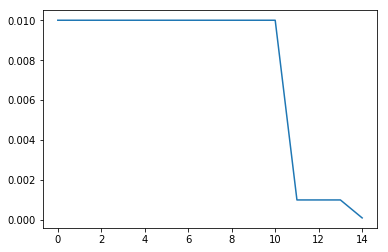

In [18]:
plt.plot(lrs)

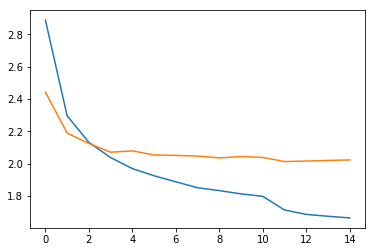

In [19]:
plt.plot(train_losses)
plt.plot(valid_losses)

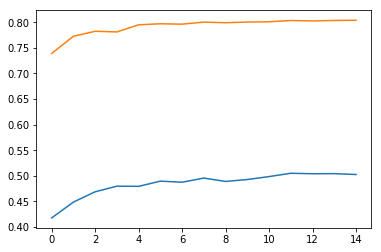

In [20]:
plt.plot(accs)
plt.plot(acc_ks)

### Evaluations

With 486 target classes, it is almost impossible to diagnose how well your model performs by looking at confusion matrix like you would normally do. Here we provide the idea of an "accuracy curve" as possible model evaluation tool.

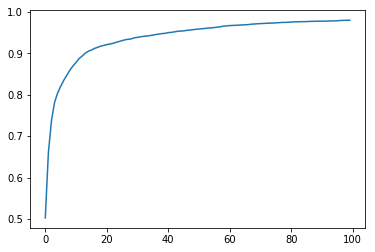

In [21]:
#accurayc curve
acc_curve_sta = []
for i in tqdm_notebook(range(1,101)):
    acc_curve_sta.append(score_topk_probs(probs,y,k=i))
plt.plot(acc_curve_sta)

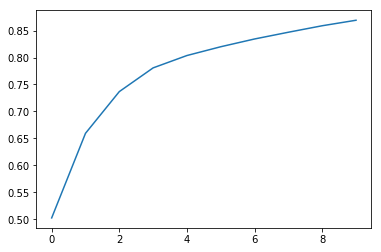

In [22]:
_ = plt.plot(acc_curve_sta[:10])

## Sequential Model

The model is essentially the same as cross-sectional model, except for the fact that we treat `prev_snap_4` to `prev_snap_1` as sequential categorical features, and put them through recurrent layers. `org`, `project`, and `user` are treated the same way as cross-sectional model.

### Dataloaders

This dataloader will output a tuple of three elements: (`sequential variables`, `cross-sectional variables`, `target`).

In [23]:
class SnapSeqDataset(Dataset):
    def __init__(self, df, seq_cols, sta_cols, target_col):
        self.df  = df
        self.seq = df[seq_cols]
        self.sta = df[sta_cols]
        self.target = df[target_col]

    def __getitem__(self, index):
        return(torch.tensor(self.seq.iloc[index], dtype=torch.long, device=device),
               torch.tensor(self.sta.iloc[index], dtype=torch.long, device=device),
               torch.tensor(self.target[index], dtype=torch.long, device=device))

    def __len__(self):
        return(self.df.shape[0])

In [24]:
seq_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1',]
sta_cols = ['org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapSeqDataset(train_df, seq_cols, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = SnapSeqDataset(valid_df, seq_cols, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)

In [25]:
next(iter(train_dl))

[tensor([[ 48, 158, 281, 158],
         [  0,   0,   0,   0],
         [158, 498, 158, 313],
         ...,
         [  0,   0,   0,   0],
         [  0, 403, 158,  85],
         [  0,   0, 294, 334]], device='cuda:0'), tensor([[  3, 500, 168],
         [  3, 500,  71],
         [  3, 500,  71],
         ...,
         [  3, 500, 118],
         [  3, 500, 118],
         [  3, 500,  71]], device='cuda:0'), tensor([313, 338, 349,  ..., 280, 158, 294], device='cuda:0')]

### Architecture

Same as before, we put all categorical indice through embedding layers to get embedding tensors. But before we concatenate them together and put them through non-linearity layers, we put the sequential variables through recurrent layers.

In [26]:
sta_dict = {'org':5, 'project':581, 'user':231}
seq_dim = 501
config = {'emb_p': 0.05, 
          'rnn_p':0., 'rnn_l':1, 'rnn_h':1000, 'seq_len': 4,
          'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500], 
          'out_sz': 501}

#rule of thump for choosing embedding size from fastai
def emb_sz_rule(n_cat): return min(600, round(1.6 * n_cat**0.56))

class RecommendSeq(nn.Module):
    def __init__(self, config, sta_dict, seq_dim):
        super(RecommendSeq, self).__init__()
        #set parameters
        self.sta_dict = sta_dict
        self.seq_dim = seq_dim
        self.emb_p = config['emb_p']
        self.rnn_p = config['rnn_p']
        self.rnn_l = config['rnn_l']
        self.rnn_h = config['rnn_h']
        self.seq_len = config['seq_len']
        self.fc_szs = config['fc_szs']
        self.fc_ps = config['fc_ps']
        self.out_sz = config['out_sz']
        
        #embedding layers
        self.emb_drop = nn.Dropout(self.emb_p)
        self.sta_layers = nn.ModuleList([nn.Embedding(sta_dict[i], emb_sz_rule(sta_dict[i])) for i in sta_dict])
        self.seq_layer = nn.Embedding(seq_dim, emb_sz_rule(seq_dim))
        self.lin_in = sum([emb_sz_rule(sta_dict[i]) for i in sta_dict]) + self.rnn_h * self.seq_len
        self.fc_szs = [self.lin_in] + self.fc_szs
        
        #recurrent layers
        self.rnn_layers = nn.LSTM(emb_sz_rule(seq_dim), self.rnn_h,
                                   num_layers = self.rnn_l, bias=True, batch_first=True,
                                   dropout=self.rnn_p)
        
        #fully connected layers
        fc_layers_list = []
        for ni,nf,p in zip(self.fc_szs[:-1], self.fc_szs[1:], self.fc_ps):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        #output head
        self.head = torch.nn.Linear(in_features=self.fc_szs[-1], out_features=self.out_sz)

    def forward(self, seq_input, sta_input):
        #sta
        sta_list = [e(sta_input[:,i]) for i,e in enumerate(self.sta_layers)]
        sta_out = torch.cat(sta_list,1)
        sta_out = self.emb_drop(sta_out)
        
        #seq
        bs = seq_input.shape[0]
        seq_out = self.seq_layer(seq_input)
        seq_out = self.emb_drop(seq_out)
        seq_out, seq_h = self.rnn_layers(seq_out)
        seq_out = seq_out.contiguous()
        seq_out = seq_out.view(bs,-1)
        
        #linear
        lin_in = torch.cat([sta_out,seq_out],1)
        res = self.fc_layers(lin_in)
        res = self.head(res)
        
        return(res)

In [27]:
model = RecommendSeq(config, sta_dict, seq_dim).to(device)
x = next(iter(valid_dl))
seq_input = x[0]
sta_input = x[1]
target = x[2]
model(seq_input,sta_input).shape

torch.Size([14792, 501])

In [28]:
model

RecommendSeq(
  (emb_drop): Dropout(p=0.05)
  (sta_layers): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(581, 57)
    (2): Embedding(231, 34)
  )
  (seq_layer): Embedding(501, 52)
  (rnn_layers): LSTM(52, 1000, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=4095, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
  )
  (head): Linear(in_features=500, out_features=501, bias=True)
)

### Training

We perform training with a high learning rate then gradually lowers it as validation loss stagnates.

In [29]:
seq_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1',]
sta_cols = ['org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapSeqDataset(train_df, seq_cols, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = SnapSeqDataset(valid_df, seq_cols, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)

In [30]:
sta_dict = {'org':5, 'project':581, 'user':231}
seq_dim = 501
config = {'emb_p': 0.05, 
          'rnn_p':0., 'rnn_l':1, 'rnn_h':1000, 'seq_len': 4,
          'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500], 
          'out_sz': 501}

model = RecommendSeq(config, sta_dict, seq_dim).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

In [31]:
train_losses = []
valid_losses = []
lrs = []
accs = []
acc_ks = []
best_loss = np.inf
best_weights = None
no_improvements = 0

for epoch in tqdm_notebook(range(20)):
    #current lr
    lr = scheduler.optimizer.param_groups[0]['lr']
    lrs.append(lr)
    #train
    train_loss = []
    model.train()
    for x in train_dl:
        seq_input = x[0]
        sta_input = x[1]
        target = x[2]
        
        #forward
        score = model(seq_input,sta_input)
        
        #loss
        loss = loss_function(score,target)
        train_loss.append(loss.item())
        
        #step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(np.mean(train_loss))
    
    #validate
    model.eval()
    for x in valid_dl:
        seq_input = x[0]
        sta_input = x[1]
        target = x[2]
        
        #forward
        score = model(seq_input,sta_input)
        
        #loss
        valid_loss = loss_function(score,target)
        valid_losses.append(valid_loss.item())
        
        #accuracy
        y = target.cpu().detach().numpy()
        probs = F.softmax(score,1).cpu().detach().numpy()
        
        #top 1 accuracy
        preds = probs.argmax(1)
        acc = (preds==y).mean()
        accs.append(acc)
        
        #top k accuracy
        acc_k = score_topk_probs(probs,y,k=5)
        acc_ks.append(acc_k)
        
    #choose best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    #early stopping
    if no_improvements > 2:
        print(f'early stopping after epoch {epoch}')
        break
        
    #end of epoch
    scheduler.step(valid_loss)
    print(f'{epoch} train loss: {round(np.mean(train_loss),3)} valid loss: {round(valid_loss.item(),3)}\
            accuracy: {round(acc,3)}  top-5 accuracy: {round(acc_k,3)}')

0 train loss: 3.093 valid loss: 2.456            accuracy: 0.417  top-5 accuracy: 0.714
1 train loss: 2.35 valid loss: 2.167            accuracy: 0.459  top-5 accuracy: 0.77
2 train loss: 2.13 valid loss: 2.092            accuracy: 0.483  top-5 accuracy: 0.784
3 train loss: 2.001 valid loss: 2.044            accuracy: 0.483  top-5 accuracy: 0.793
4 train loss: 1.921 valid loss: 2.007            accuracy: 0.492  top-5 accuracy: 0.793
5 train loss: 1.863 valid loss: 2.005            accuracy: 0.498  top-5 accuracy: 0.789
6 train loss: 1.816 valid loss: 2.016            accuracy: 0.503  top-5 accuracy: 0.797
7 train loss: 1.783 valid loss: 2.0            accuracy: 0.5  top-5 accuracy: 0.79
8 train loss: 1.755 valid loss: 1.989            accuracy: 0.507  top-5 accuracy: 0.798
9 train loss: 1.735 valid loss: 1.979            accuracy: 0.506  top-5 accuracy: 0.792
10 train loss: 1.712 valid loss: 1.974            accuracy: 0.505  top-5 accuracy: 0.8
11 train loss: 1.698 valid loss: 1.981   

In [ ]:
#save model
# torch.save(best_weights,'seq_weights.pth')

### Diagnostics

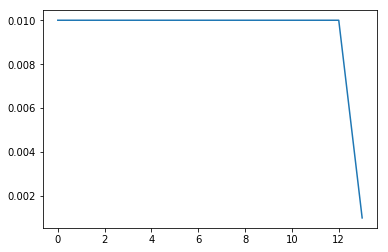

In [32]:
plt.plot(lrs)

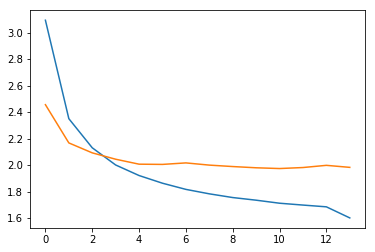

In [33]:
plt.plot(train_losses)
plt.plot(valid_losses)

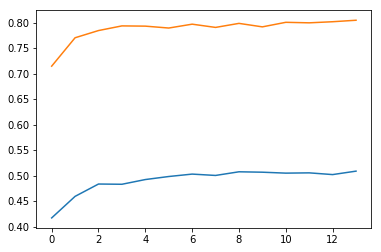

In [34]:
plt.plot(accs)
plt.plot(acc_ks)

### Evaluation

Here we can also compare performance between cross-sectional and sequential models. You can see they are very close.

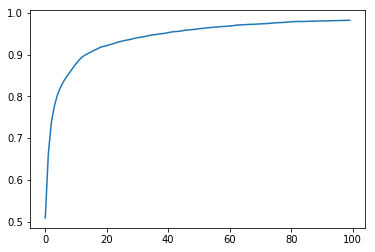

In [35]:
#accurayc curve
acc_curve_seq = []
for i in tqdm_notebook(range(1,101)):
    acc_curve_seq.append(score_topk_probs(probs,y,k=i))
plt.plot(acc_curve_seq)

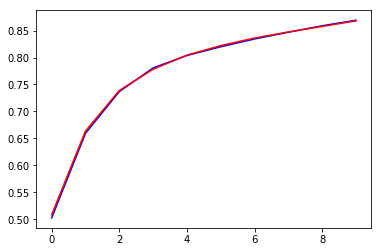

In [36]:
plt.plot(acc_curve_sta[:10],'b')
plt.plot(acc_curve_seq[:10],'r')